In [1]:
# Import necessary libraries for data manipulation, statistical modeling, and visualization.
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the weekly data from a CSV file
# note:the csv file is not shared on github due to Strava's data policy!
df = pd.read_csv('Main data/main_weekly.csv')

### Data Cleaning
Remove any rows with missing or zero values in critical columns.

In [3]:
# Drop rows with missing values in specific columns
df = df.dropna(subset=['value', 'total_trip_count', 'rain'])

# Remove rows where 'value' or 'total_trip_count' are zero, as they are likely erroneous or uninformative
df = df[df['value'] != 0]
df = df[df['total_trip_count'] != 0]

### Define Variables
Specify the target and feature variables for the model.

In [4]:
# weekly
Y = df['value']
X = df[['total_trip_count','rain','Area_CC','Area_N','Area_SE', 'Area_NE','Bike_Lanes',
        'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
        'month_11', 'month_12']]
X_list = ['total_trip_count','rain','Area_CC','Area_N','Area_SE', 'Area_NE','Bike_Lanes',
        'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
        'month_11', 'month_12']

In [5]:
# Check for NaN and infinite values in X
print("NaNs or Infs in X:", np.any(np.isnan(X)) or np.any(np.isinf(X)))

# Check for NaN and infinite values in Y
print("NaNs or Infs in Y:", np.any(np.isnan(Y)) or np.any(np.isinf(Y)))


NaNs or Infs in X: False
NaNs or Infs in Y: False


In [6]:
df.head(10)

,location,time,total_trip_count,value,Bike_Lanes,month_2,month_3,month_4,month_5,month_6,...,month_12,rain,Area_N,Area_NE,Area_NW,Area_S,Area_SE,Area_SW,Area_W,Area_CC
0,Charleville Mall,05/01/2020,70,295,1,0,0,0,0,0,...,0,2.4,0,1,0,0,0,0,0,0
1,Charleville Mall,12/01/2020,425,771,1,0,0,0,0,0,...,0,24.2,0,1,0,0,0,0,0,0
4,Charleville Mall,02/02/2020,50,890,1,1,0,0,0,0,...,0,3.5,0,1,0,0,0,0,0,0
5,Charleville Mall,09/02/2020,395,875,1,1,0,0,0,0,...,0,49.5,0,1,0,0,0,0,0,0
6,Charleville Mall,16/02/2020,120,678,1,1,0,0,0,0,...,0,39.2,0,1,0,0,0,0,0,0
8,Charleville Mall,01/03/2020,45,749,1,0,1,0,0,0,...,0,11.7,0,1,0,0,0,0,0,0
9,Charleville Mall,08/03/2020,405,912,1,0,1,0,0,0,...,0,3.4,0,1,0,0,0,0,0,0
10,Charleville Mall,15/03/2020,210,821,1,0,1,0,0,0,...,0,19.9,0,1,0,0,0,0,0,0
13,Charleville Mall,05/04/2020,275,367,1,0,0,1,0,0,...,0,3.9,0,1,0,0,0,0,0,0
14,Charleville Mall,12/04/2020,285,501,1,0,0,1,0,0,...,0,1.8,0,1,0,0,0,0,0,0


### data checks

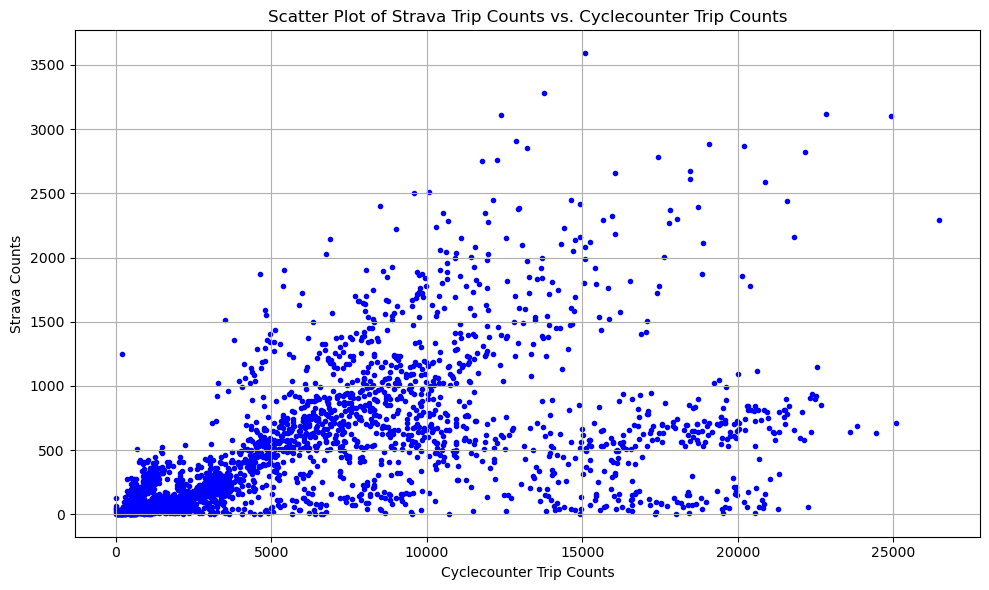

In [7]:
#Plot scatter plot for the two variables
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['value'], df['total_trip_count'], color='blue', marker='.')

# Add labels and title
plt.xlabel('Cyclecounter Trip Counts')
plt.ylabel('Strava Counts')
plt.title('Scatter Plot of Strava Trip Counts vs. Cyclecounter Trip Counts')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# Calculate VIF: Variance Inflation Factor, detects multicolinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [sm.OLS(X.iloc[:, i], sm.add_constant(X.drop(X.columns[i], axis=1))).fit().rsquared for i in range(X.shape[1])]
    vif_data["VIF"] = 1 / (1 - vif_data["VIF"])
    return vif_data

vif_data = calculate_vif(X)
print("VIF Data:")
print(vif_data)

VIF Data:
            Variable       VIF
0   total_trip_count  1.265705
1               rain  1.082538
2            Area_CC  1.509486
3             Area_N  1.140086
4            Area_SE  1.598782
5            Area_NE  1.137646
6         Bike_Lanes  1.232738
7            month_2  1.723361
8            month_3  1.773050
9            month_4  1.826303
10           month_5  1.901019
11           month_6  1.767794
12           month_7  1.855029
13           month_8  1.846565
14           month_9  1.824448
15          month_10  1.947705
16          month_11  1.784886
17          month_12  1.497793


No Multicollinearity detected

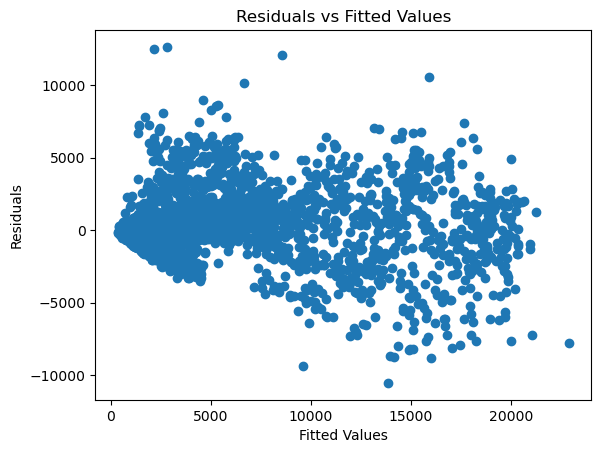

In [9]:
# Plot residuals to check for homoscedasticity:
ols_results = sm.OLS(Y, sm.add_constant(X)).fit()
residuals = ols_results.resid

plt.scatter(ols_results.fittedvalues, residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


Note: potential heteroskedasticity issue. Will also try WLS 

## Regression - Train/Test

In [10]:
# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.1, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Add a constant term for the intercept
X_train_const = sm.add_constant(X_train)
X_val_const = sm.add_constant(X_val)
X_test_const = sm.add_constant(X_test)

### OLS Regression
# Fit OLS model on the training data
ols_model = sm.OLS(Y_train, X_train_const)
ols_results = ols_model.fit()

# Validate the OLS model on the validation set
Y_val_pred_ols = ols_results.predict(X_val_const)
rmse_val_ols = np.sqrt(np.mean((Y_val - Y_val_pred_ols) ** 2))
mae_val_ols = mean_absolute_error(Y_val, Y_val_pred_ols)

# Test the OLS model on the test set
Y_test_pred_ols = ols_results.predict(X_test_const)
rmse_test_ols = np.sqrt(np.mean((Y_test - Y_test_pred_ols) ** 2))
mae_test_ols = mean_absolute_error(Y_test, Y_test_pred_ols)

# Print OLS training summary and accuracy
print("OLS Training Summary:")
print(ols_results.summary())

r2_ols = r2_score(Y_test, Y_test_pred_ols)
accuracy_ols = r2_ols * 100
print(f'OLS Accuracy: {accuracy_ols:.2f}%')
print(f"Validation RMSE (OLS): {rmse_val_ols:.4f}")
print(f"Test RMSE (OLS): {rmse_test_ols:.4f}")
print(f"Test MAE (OLS): {mae_test_ols:.4f}")

### WLS Regression
# Calculate residuals from the OLS model
residuals = ols_results.resid

# Handle very small residuals to avoid division by zero
residuals = np.where(residuals == 0, 1e-10, residuals)

# Calculate weights based on the residuals
weights = 1 / (residuals ** 2)
weights = np.clip(weights, 1e-5, None)  # Normalize weights if necessary

# Fit the WLS model on the training set
wls_model = sm.WLS(Y_train, X_train_const, weights=weights)
wls_results = wls_model.fit()

# Validate the WLS model on the validation set
Y_val_pred_wls = wls_results.predict(X_val_const)
rmse_val_wls = np.sqrt(np.mean((Y_val - Y_val_pred_wls) ** 2))
mae_val_wls = mean_absolute_error(Y_val, Y_val_pred_wls)

# Test the WLS model on the test set
Y_test_pred_wls = wls_results.predict(X_test_const)
rmse_test_wls = np.sqrt(np.mean((Y_test - Y_test_pred_wls) ** 2))
mae_test_wls = mean_absolute_error(Y_test, Y_test_pred_wls)

# Calculate unweighted R-squared
absolute_errors = np.abs(Y_test - Y_test_pred_wls)
absolute_error_variance = np.var(absolute_errors)
dependent_data_variance = np.var(Y_test)
unweighted_r2 = 1.0 - (absolute_error_variance / dependent_data_variance)

# Print WLS training summary and accuracy
print("WLS Training Summary:")
print(wls_results.summary())

r2_wls = r2_score(Y_test, Y_test_pred_wls)
accuracy_wls = r2_wls * 100
print(f'WLS Accuracy: {accuracy_wls:.2f}%')
print(f"Validation RMSE (WLS): {rmse_val_wls:.4f}")
print(f"Test RMSE (WLS): {rmse_test_wls:.4f}")
print(f"Test MAE (WLS): {mae_test_wls:.4f}")
print(f"Unweighted R-squared (WLS): {unweighted_r2:.4f}")

### MLE Regression (Generalized Linear Model with Gaussian Family)
# Fit the MLE model on the training data
mle_model = sm.GLM(Y_train, X_train_const, family=sm.families.Gaussian())
mle_results = mle_model.fit()

# Validate the MLE model on the validation set
Y_val_pred_mle = mle_results.predict(X_val_const)
rmse_val_mle = np.sqrt(np.mean((Y_val - Y_val_pred_mle) ** 2))
mae_val_mle = mean_absolute_error(Y_val, Y_val_pred_mle)

# Test the MLE model on the test set
Y_test_pred_mle = mle_results.predict(X_test_const)
rmse_test_mle = np.sqrt(np.mean((Y_test - Y_test_pred_mle) ** 2))
mae_test_mle = mean_absolute_error(Y_test, Y_test_pred_mle)

# Print MLE training summary and accuracy
print("MLE Training Summary:")
print(mle_results.summary())

r2_mle = r2_score(Y_test, Y_test_pred_mle)
accuracy_mle = r2_mle * 100
print(f'MLE Accuracy: {accuracy_mle:.2f}%')
print(f"Validation RMSE (MLE): {rmse_val_mle:.4f}")
print(f"Test RMSE (MLE): {rmse_test_mle:.4f}")
print(f"Test MAE (MLE): {mae_test_mle:.4f}")


OLS Training Summary:
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     640.1
Date:                Wed, 21 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:54:42   Log-Likelihood:                -23466.
No. Observations:                2547   AIC:                         4.697e+04
Df Residuals:                    2528   BIC:                         4.708e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -

the three estimaters returned very similar results. We head for OLS.

## Regression - entire dataset, OLS

In [11]:
# Add a constant term to X
X_const = sm.add_constant(X)

# Train models on the entire dataset
# OLS Model
ols_model = sm.OLS(Y, X_const)
ols_results = ols_model.fit()

Y_pred = ols_results.predict(X_const)
mae_ols = mean_absolute_error(Y, Y_pred)

# Calculate unweighted R-squared
absolute_errors = np.abs(Y - Y_pred)
absolute_error_variance = np.var(absolute_errors)
dependent_data_variance = np.var(Y)

# Print WLS training summary and accuracy
print("OLS Training Summary:")
print(ols_results.summary())


print(f'OLS Accuracy: {accuracy_ols:.2f}%')
print(f"Validation RMSE (WLS): {rmse_val_ols:.4f}")
print(f"Test RMSE (WLS): {rmse_test_ols:.4f}")
print(f"Test MAE (WLS): {mae_ols:.4f}")

OLS Training Summary:
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     724.5
Date:                Wed, 21 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:54:42   Log-Likelihood:                -26053.
No. Observations:                2831   AIC:                         5.214e+04
Df Residuals:                    2812   BIC:                         5.226e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -

In [12]:
summary = ols_results.summary()
# Extract tables into DataFrames
params_df = pd.DataFrame(ols_results.params, columns=['Coefficient'])
params_df['Standard Error'] = ols_results.bse
params_df['t-Statistic'] = ols_results.tvalues
params_df['P-Value'] = ols_results.pvalues

# Convert summary tables to Excel
with pd.ExcelWriter('ols_summary.xlsx') as writer:
    params_df.to_excel(writer, sheet_name='Parameters')
    
    # Optionally, extract and save additional summary statistics or tables
    # For example:
    # additional_stats_df = pd.DataFrame(...)
    # additional_stats_df.to_excel(writer, sheet_name='Additional Stats')

print("Summary has been exported to 'ols_summary.xlsx'")

Summary has been exported to 'ols_summary.xlsx'


## Robustness Check

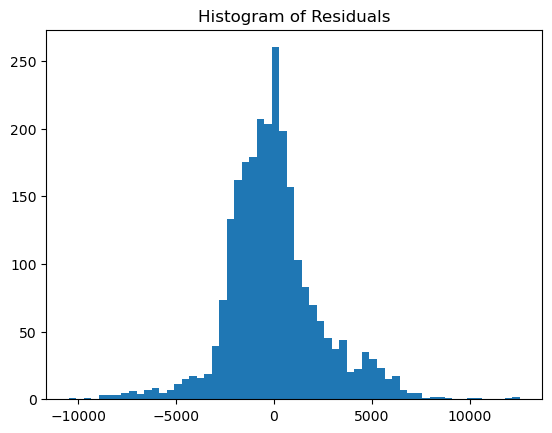

In [13]:
# Histogram of Residuals - check whether the residuals are normally distributed
import scipy.stats as stats
plt.hist(wls_results.resid, bins=60)
plt.title('Histogram of Residuals')
plt.show()

/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_85270/2782127468.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, color='red')


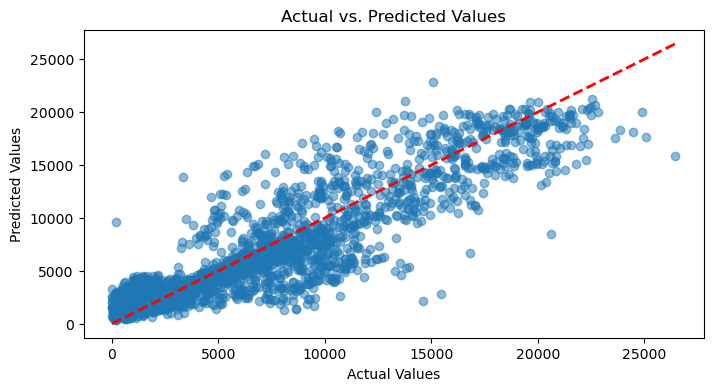

In [14]:
# Actual vs. Predicted Plot
plt.figure(figsize=(8, 4))
plt.scatter(Y, Y_pred, alpha=0.5)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

## Validation

In [15]:
# Function to validate and plot predictions for a specific location
def validate_and_plot(location):
    # Filter data for the specific location
    location_data = df[df['location'] == location]
    
    X_loc = location_data[X_list]
    Y_loc = location_data['value']
    time_loc = location_data['time']
    
    # Add a constant term for the intercept (ensure X_loc_const has the same shape as X_const)
    X_loc_const = sm.add_constant(X_loc, has_constant='add')
    
    # Predict using the trained model
    Y_pred_wls = wls_results.predict(X_loc_const)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(Y_loc, Y_pred_wls))
    
    # Normalize RMSE by the range of the actual values
    accu = 1- rmse / (Y_loc.max() - Y_loc.min())
    accu = abs(accu*100)
    # Plot the results
    plt.figure(figsize=(8, 3))
    
    # Plot original vs predicted values for the model
    plt.plot(time_loc, Y_loc, label='Ground Truth Values', color='black')
    plt.plot(time_loc, Y_pred_wls, label='Model Predictions', linestyle='--', color='green')
    
    # Add NRMSE to the plot
    plt.text(0.2, 0.9, f'accuracy = {accu:.3}%', fontsize=8, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    plt.xlabel('Time',fontsize=8)
    plt.ylabel('')
    plt.title(f'Original vs Predicted Values for Location: {location}',fontsize=10)
    plt.xticks([]) 
    plt.yticks( fontsize=8 ) 
    plt.legend(fontsize=8)
    plt.grid(False)
    plt.show()


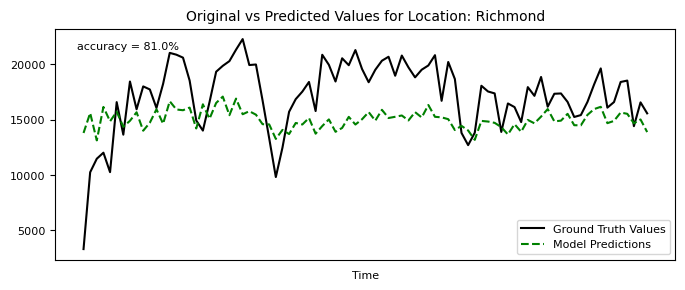

In [16]:
validate_and_plot('Richmond')

## Visulisation

### Map of all the cycle counetrs

In [17]:
import folium

# Create a map centered around Dublin
map_dublin = folium.Map(location=[53.3498, -6.2603], zoom_start=12)

# List of locations with their coordinates
locations = {
    "Clonskeagh": (53.3125, -6.2289),
    "Wyattville Rd": (53.2551, -6.1389),
    "North Strand": (53.3584, -6.2417),
    "Rock Rd": (53.3166, -6.2024),
    "N11 Inbound": (53.3094, -6.1934),
    "Rock Road Park": (53.3138, -6.2014),
    "Grange Rd": (53.2879, -6.2833),
    "Charleville Mall": (53.3555, -6.2476),
    "Guild Street": (53.3500, -6.2412),
    "Grove Road Totem": (53.3206, -6.2654),
    "Wyattville Pk": (53.2540, -6.1283),
    "N11 Outbound": (53.2978, -6.1819),
    "Wyattville Pk Steps": (53.2531, -6.1279),
    "York Road": (53.2927, -6.1516),
    "Peoples Park": (53.2922, -6.1337),
    "Seapoint": (53.3013, -6.1569),
    "Richmond": (53.3312736,-6.2671337),
    "Drumcondra": (53.3671, -6.2572),
    "Glenageary": (53.2783, -6.1214),
    "Clontarf - Pebble Beach Carpark": (53.3619, -6.2033),
    "Griffith Avenue": (53.3727, -6.2528)
}

# Add each location to the map with a marker
for location, coords in locations.items():
    folium.Marker(
        location=coords,
        popup=location,
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(map_dublin)

# Display the map
map_dublin.save("dublin_map.html")

# Optionally, to display it directly in a Jupyter notebook, use:

display(map_dublin)


## Visualise different routes

In [18]:
df = pd.read_csv('Route Based Analysis/weekly prediction.csv')

/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_85270/2544288766.py:3: UserWarning: Parsing '17/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_85270/2544288766.py:3: UserWarning: Parsing '24/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_85270/2544288766.py:3: UserWarning: Parsing '31/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_85270/2544288766.py:3: UserWarning: Parsing '14/02/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] =

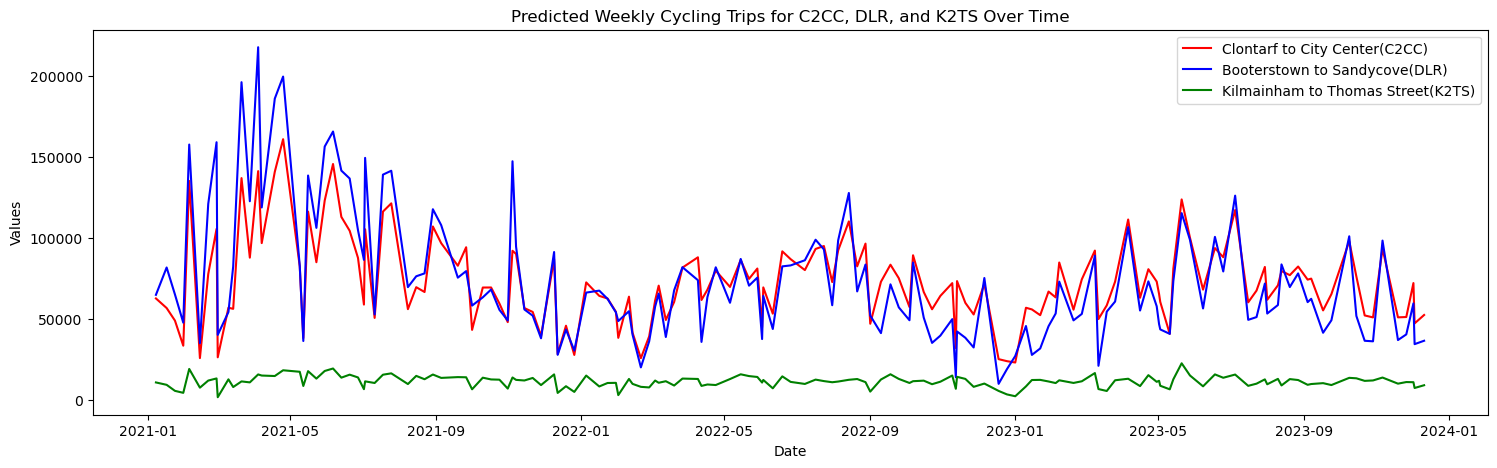

In [19]:

# Assuming 'df' has columns 'date', 'C2CC', 'DLR', 'K2TC'
# Convert 'date' to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'])

# Set the plot size
plt.figure(figsize=(18, 5))

# Plot each column on the same line chart
sns.lineplot(data=df, x='date', y='C2CC', color = 'red', label='Clontarf to City Center(C2CC)')
sns.lineplot(data=df, x='date', y='DLR', color = 'blue', label='Booterstown to Sandycove(DLR)')
sns.lineplot(data=df, x='date', y='K2TC', color = 'green', label='Kilmainham to Thomas Street(K2TS)')

# Add title and labels
plt.title('Predicted Weekly Cycling Trips for C2CC, DLR, and K2TS Over Time')
plt.xlabel('Date')
plt.ylabel('Values')

# Display the legend
plt.legend()

# Show the plot
plt.show()